In [1]:
"""
Imports pandas, numpy, re and datetime/time to the project
Returns the read csv file SAdf.csv
"""
import pandas as pd
import numpy as np
import re
from datetime import time

SAdf = pd.read_csv('SAdf.csv')

In [2]:
"""
Cleans and standardizes the 'Type' column in the DataFrame SAdf.
 
Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Type' column.

Returns:
    pd.DataFrame: The modified DataFrame.
"""

# Standardize the 'Type' column: convert to string, strip whitespace, and Title Case
SAdf['Type'] = SAdf['Type'].astype(str).str.strip().str.title()

# Define the list of allowed (canonical) values
canonical_types = ['Unprovoked', 'Provoked']

# Replace any value not in the canonical list with 'Unknown'
SAdf['Type'] = SAdf['Type'].mask(~SAdf['Type'].isin(canonical_types), 'Unknown')

SAdf
# Example of how you would call this function (assuming SAdf is defined):
# SAdf = clean_shark_attack_type(SAdf)

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N
0,2025,29th September,0100hrs,Unprovoked,M,54,Swimming,Catalina Island,USA,Off California,N
1,2025,1st September,1524hrs,Unprovoked,M,8,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N
2,2025,30th August,Not stated,Unprovoked,F,8,Swimming,Galveston,USA,Texas,N
3,2025,16th August,1055 hrs,Provoked,M,?,Fishing,Cayo Costa Boca Grande,USA,Florida,N
4,2025,19th July,Not stated,Unprovoked,M,69,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N
...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,Afternoon,Provoked,M,29,Measuring sharks,Hanalei Bay,USA,Florida,N
816,2010,19-Apr-2010,16h00,Unprovoked,M,68,Surfing,"Hanalei Bay, Kauai",USA,Hawaii,N
817,2010,06-Feb-2010,15h00,Provoked,M,NaN,Surf fishing / wading,Riviera Beach,USA,Florida,N
818,2010,03-Feb-2010,15h44,Unprovoked,M,38,Kite Boarding,"Stuart, Martin County",USA,Florida,Y


In [3]:
"""
Performs multi-step cleaning and standardization on the 'Time' column of the DataFrame.
 
The process involves:
1. Creating a temporary column ('Time_Cleaned').
2. Using regex to standardize various formats (xxhxx, xxxxhrs, decimal) into 'HH:MM'.
3. Filtering out descriptive/range values and setting them to NaN.
4. Coercing the standardized strings into datetime.time objects in the original 'Time' column.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time' column.

Returns:
    pd.DataFrame: The modified DataFrame with the cleaned 'Time' column and 
                  without the temporary 'Time_Cleaned' column.
"""

# 1. Removing white spaces and ensuring string type
# Create the temporary column 'Time_Cleaned' directly from the string version of 'Time'.
SAdf['Time_Cleaned'] = SAdf['Time'].fillna('').astype(str).apply(str.strip)

# 2. Step 1: Standardize Common Patterns using Regex 

# Pattern 1: xxhxx (e.g., '12h30', '9h0')
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(\d{1,2})h(\d{0,2})$',
    lambda m: f"{int(m.group(1)):02d}:{m.group(2).zfill(2)}", # Format to 09:00, 13:15
    regex=True
)

# Pattern 2 & 3: Consolidated xxxxhrs/hr OR numeric-only time (e.g., '0100hrs', '1524', '100hrs')
def military_time_formatter(match):
    # m.group(1) is the digits (e.g., '100' or '1524')
    digits = match.group(1)
    
    # 1. Pad to 4 digits (e.g., '100' -> '0100')
    padded_digits = digits.zfill(4)
    
    # 2. Extract HH and MM and join with a colon (e.g., '0100' -> '01:00')
    return f"{padded_digits[:2]}:{padded_digits[-2:]}"

# Combine matching for xxxxhrs (Pattern 2)
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(\d{3,4})\s*hrs?$', 
    military_time_formatter,
    regex=True
)

# Combine matching for xxxx (Pattern 3)
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(?!\d{1,2}h)(\d{3,4})$', # Numeric only, not already matched by xxhxx
    military_time_formatter,
    regex=True
)

# Pattern 4: decimal time (e.g., '15.5')
def convert_decimal(match):
    hour = int(match.group(1))
    # m.group(2) is the decimal part (e.g., '5')
    # We need to calculate minutes from the decimal part (e.g., 0.5 * 60 = 30)
    minute = int(round(float(f"0.{match.group(2)}")) * 60)
    # Ensure hour padding here as well
    return f"{hour:02d}:{minute:02d}"

SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].str.replace(
    r'^(\d{1,2})\.(\d{1,2})$', 
    convert_decimal, 
    regex=True
)

# 3. Step 2: Handle Ranges, Descriptions, and Unknowns 

# Values that are ranges, descriptive, or malformed should be set to NaN (missing)
descriptive_or_range_values = [
    'Not stated', 'AM', '?', 'after 1200hr', '14h00-15h00', '14h00  -15h00',
    'Late afternoon', '14h30 / 15h30', 'Morning ', '09h30 / 10h00',
    '10h45-11', 'Night', 'Afternoon', 'Early Morning', 'Evening', 
    'Lunchtime', 'Unknown', '' # Added common descriptive/empty values to the list
]

# Replace values that match the list with NaN
SAdf['Time_Cleaned'] = SAdf['Time_Cleaned'].replace(descriptive_or_range_values, np.nan)

# 4. Step 3: Convert the cleaned string time to a datetime.time object
# This step will convert the 'HH:MM' string to a proper time object, leaving NaNs as NaNs.
def string_to_time(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        # Use pandas to_datetime and extract the time part
        return pd.to_datetime(time_str, format='%H:%M', errors='coerce').time()
    except Exception:
        # Catch any remaining malformed strings
        return np.nan

SAdf['Time'] = SAdf['Time_Cleaned'].apply(string_to_time)

# 5. Drop the temporary column
SAdf = SAdf.drop(columns=['Time_Cleaned'])

SAdf

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N
0,2025,29th September,01:00:00,Unprovoked,M,54,Swimming,Catalina Island,USA,Off California,N
1,2025,1st September,15:24:00,Unprovoked,M,8,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N
2,2025,30th August,NaN,Unprovoked,F,8,Swimming,Galveston,USA,Texas,N
3,2025,16th August,10:55:00,Provoked,M,?,Fishing,Cayo Costa Boca Grande,USA,Florida,N
4,2025,19th July,NaN,Unprovoked,M,69,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N
...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,NaN,Provoked,M,29,Measuring sharks,Hanalei Bay,USA,Florida,N
816,2010,19-Apr-2010,16:00:00,Unprovoked,M,68,Surfing,"Hanalei Bay, Kauai",USA,Hawaii,N
817,2010,06-Feb-2010,15:00:00,Provoked,M,NaN,Surf fishing / wading,Riviera Beach,USA,Florida,N
818,2010,03-Feb-2010,15:44:00,Unprovoked,M,38,Kite Boarding,"Stuart, Martin County",USA,Florida,Y


In [4]:
"""
Creates a 'Time_Range' column based on the hour extracted from the 'Time' column.
NaN values resulting from missing 'Time' data are renamed to 'Unknown'.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time' column (expected 
                          to contain datetime.time objects or pandas.NaT).

Returns:
    pd.DataFrame: The modified DataFrame with the new 'Time_Range' column.
"""


def categorize_time(time_obj):
    """
    Categorizes a datetime.time object into a descriptive time range.
    """
    # If the time is NaT (missing or invalid), return NaN
    if pd.isna(time_obj):
        return np.nan
    
    # Extract the hour component (0-23)
    hour = time_obj.hour

    if 6 <= hour < 12:
        return 'Morning'         # 06:00:00 to 11:59:59
    elif 12 <= hour < 17:
        return 'Afternoon'       # 12:00:00 to 16:59:59 (Noon to 5 PM)
    elif 17 <= hour < 22:
        return 'Evening'         # 17:00:00 to 21:59:59 (5 PM to 10 PM)
    else: # 22 <= hour <= 23 OR 0 <= hour < 6
        return 'Night'           # 22:00:00 to 05:59:59 (10 PM to 6 AM)

# Apply the categorization function to the cleaned 'Time' column
SAdf['Time_Range'] = SAdf['Time'].apply(categorize_time)

# Replace NaN values with 'Unknown'
SAdf['Time_Range'] = SAdf['Time_Range'].fillna('Unknown')
    
SAdf

# Example of how you would call this function (assuming SAdf is defined):
# SAdf = create_time_range_column(SAdf)

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N,Time_Range
0,2025,29th September,01:00:00,Unprovoked,M,54,Swimming,Catalina Island,USA,Off California,N,Night
1,2025,1st September,15:24:00,Unprovoked,M,8,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N,Afternoon
2,2025,30th August,NaN,Unprovoked,F,8,Swimming,Galveston,USA,Texas,N,Unknown
3,2025,16th August,10:55:00,Provoked,M,?,Fishing,Cayo Costa Boca Grande,USA,Florida,N,Morning
4,2025,19th July,NaN,Unprovoked,M,69,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,NaN,Provoked,M,29,Measuring sharks,Hanalei Bay,USA,Florida,N,Unknown
816,2010,19-Apr-2010,16:00:00,Unprovoked,M,68,Surfing,"Hanalei Bay, Kauai",USA,Hawaii,N,Afternoon
817,2010,06-Feb-2010,15:00:00,Provoked,M,NaN,Surf fishing / wading,Riviera Beach,USA,Florida,N,Afternoon
818,2010,03-Feb-2010,15:44:00,Unprovoked,M,38,Kite Boarding,"Stuart, Martin County",USA,Florida,Y,Afternoon


In [5]:
"""
Counts shark attacks by 'Time_Range' and calculates the percentage for 
each known time category, excluding 'Unknown' incidents from the total 
used for the percentage calculation.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time_Range' column.

Returns:
    pd.DataFrame: A DataFrame with 'Time Range', 'Incident Count', and 
                  'Percentage' columns.
"""
 
# 1. Calculate the count of shark attacks per time range category (including 'Unknown').
attacks_by_time_range = SAdf['Time_Range'].value_counts(dropna=False)

# 2. Convert the Series to a DataFrame and rename the count column
attacks_df = attacks_by_time_range.reset_index()
attacks_df.columns = ['Time Range', 'Incident Count']

# 3. Calculate total incidents FOR KNOWN TIMES ONLY
# Filter out 'Unknown' and count the remainder.
total_incidents_known = SAdf[SAdf['Time_Range'] != 'Unknown']['Time_Range'].count()

# 4. Create the new column for the percentage.
# The percentage is calculated relative to total_incidents_known.
# The 'Unknown' row itself is assigned 0% to reflect that it's an un-categorized incident.
attacks_df['Percentage'] = attacks_df.apply(
    lambda row: (row['Incident Count'] / total_incidents_known) * 100
    if row['Time Range'] != 'Unknown'
    else 0,
    axis=1
)

# 5. Format the percentage to two decimal places for readability
attacks_df['Percentage'] = attacks_df['Percentage'].round(2).astype(str) + '%'
 
attacks_df

# Example of how you would call this function (assuming SAdf is defined):
# time_breakdown_df = calculate_time_range_percentage(SAdf)

,Time Range,Incident Count,Percentage
0,Afternoon,300,52.17%
1,Unknown,245,0.0%
2,Morning,190,33.04%
3,Evening,78,13.57%
4,Night,7,1.22%


In [6]:
"""
Groups shark attack incidents by 'Time_Range' and 'Type', counts the incidents
in each group, and calculates the percentage of the total known time incidents.

NOTE: The current code relies on the previous step where NaN in 'Time_Range' 
was replaced with 'Unknown'. Therefore, filtering 'Time_Range'.notna() will 
exclude all incidents categorized as 'Unknown'.

Args:
    SAdf (pd.DataFrame): The DataFrame containing the 'Time_Range' and 'Type' columns.

Returns:
    pd.DataFrame: A DataFrame showing the 'Time_Range', 'Type', 'Incident Count', 
                  and 'Percentage' for all categorized time incidents.
"""
 
# 1. Filter the DataFrame to include only incidents with a known time range
# Assuming 'Unknown' is the category to exclude (as it's the old NaN).
known_time_incidents = SAdf[SAdf['Time_Range'] != 'Unknown'].copy()

# 2. Calculate the total number of known incidents (denominator for percentage)
total_known_incidents = len(known_time_incidents)

# 3. Group by Time_Range and Type, then count the size of each group
grouped_incidents = known_time_incidents.groupby(['Time_Range', 'Type']).size().reset_index(name='Incident Count')

# 4. Calculate the percentage of the total known incidents
grouped_incidents['Percentage'] = (grouped_incidents['Incident Count'] / total_known_incidents) * 100

# 5. Format the percentage column for clean display
grouped_incidents['Percentage'] = grouped_incidents['Percentage'].round(2).astype(str) + '%'
 
grouped_incidents

# Example of how you would call this function (assuming SAdf is defined):
# attack_breakdown = analyze_time_range_and_attack_type(SAdf)

,Time_Range,Type,Incident Count,Percentage
0,Afternoon,Provoked,16,2.78%
1,Afternoon,Unknown,22,3.83%
2,Afternoon,Unprovoked,262,45.57%
3,Evening,Provoked,4,0.7%
4,Evening,Unknown,12,2.09%
5,Evening,Unprovoked,62,10.78%
6,Morning,Provoked,7,1.22%
7,Morning,Unknown,18,3.13%
8,Morning,Unprovoked,165,28.7%
9,Night,Provoked,2,0.35%


In [7]:
#""" #**1. Reformat the information about the gender information in the database, as there are son extra spaces and wrong inputs.**"""

SAdf.Sex.unique()

SAdf['Sex']=SAdf.Sex.fillna('UNKNOWN')

SAdf.Sex.isna().sum()

SAdf['Sex'] = (SAdf['Sex'].astype(str).str.strip().str.upper())

SAdf.Sex.unique()

SAdf.Sex.value_counts()

#**2. Clean the null values in the Age column, format the data {Invalid symbols, Pure numbers, Age ranges like 30s, 40s, etc., Teen, Middle age, Minor, Extract all digits(handles cases like ‘!2’, ‘!6’, ‘45 and 15’, etc.)}, and then convert the Age type to integer.**

SAdf.Age.nunique()

SAdf.Age.unique()

SAdf.Age.isna().sum()

def clean_age(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if x in ['?','!!']:
        return np.nan
    if x.isdigit():
        return int(x)
    if re.match(r'^\d{2}s$', x):
        return int(x[:2])
    if 'teen' in x:
        return 15
    if 'middle' in x:
        return 45
    if 'minor' in x:
        return 10
        
    nums = re.findall(r'\d+', x)
    if len(nums) >= 1:
        return int(nums[0])

    return np.nan

SAdf['Age'] = SAdf['Age'].apply(clean_age).astype('Int32')

SAdf['Age'].unique()

SAdf['Age'].dtype

#**3.Map the original activities (Swimming, Body surfing, Surfing, Fishing, Playing… etc.) into a standardized set of activity categories：**

#- **Surfing, kite-surfing, surf fishing - > Surfing**
#- **Swimming, swimming/treading water - > Swimming**
#- **Fishing, spear-fishing, kayak fishing - > Fishing**
#- **Diving, scuba diving, free diving - > Diving**
#- **Standing, walking, wadin - > Wading/Standing**
#- **Undisclosed, Not stated, NaN  - > Unknown**


SAdf['Activity'].nunique() 

SAdf['Activity'].unique() 

SAdf['Activity_clean'] = SAdf['Activity'].str.lower().str.strip()

activity_map = {
    'surf': 'Surfing',
    'kite': 'Surfing',
    'body surf': 'Surfing',

    'swim': 'Swimming',
    'treading water': 'Swimming',

    'diving': 'Diving',
    'scuba': 'Diving',
    'snorkel': 'Diving',

    'fish': 'Fishing',
    'spear': 'Fishing',
    'lobster': 'Fishing',

    'paddle': 'Paddleboarding',
    'canoe': 'Paddleboarding',
    'kayak': 'Paddleboarding',

    'wading': 'Wading/Standing',
    'standing': 'Wading/Standing',
    'walking': 'Wading/Standing',

    'touching a shark': 'Animal Interaction',
    'feeding': 'Animal Interaction',

    'photo': 'Photography',
    'filming': 'Photography',

    'unknown': 'Unknown',
    'not stated': 'Unknown',
    'undisclosed': 'Unknown'
}

def map_activity(x):
    if pd.isna(x):
        return 'Unknown'
    x = str(x).lower()

    for key, value in activity_map.items():
        if key in x:
            return value
    return 'Other'

SAdf['Activity_grouped'] = SAdf['Activity'].apply(map_activity)

SAdf['Activity_grouped'].value_counts()

def clean_text(s):
    if isinstance(s, str):
        s = re.sub(r'[^\x00-\x7F]+', '', s)   
    return s

SAdf = SAdf.apply(lambda col: col.map(clean_text))

SAdf

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N,Time_Range,Activity_clean,Activity_grouped
0,2025,29th September,01:00:00,Unprovoked,M,54.0,Swimming,Catalina Island,USA,Off California,N,Night,swimming,Swimming
1,2025,1st September,15:24:00,Unprovoked,M,8.0,Snorkeling,Horseshoe reef Key Largo,USA,Florida,N,Afternoon,snorkeling,Diving
2,2025,30th August,NaN,Unprovoked,F,8.0,Swimming,Galveston,USA,Texas,N,Unknown,swimming,Swimming
3,2025,16th August,10:55:00,Provoked,M,NaN,Fishing,Cayo Costa Boca Grande,USA,Florida,N,Morning,fishing,Fishing
4,2025,19th July,NaN,Unprovoked,M,69.0,Diving,Jupiter Inlet off Jupiter Beach Palm Beach County,USA,Florida,N,Unknown,diving,Diving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,2010,28-Apr-2010,NaN,Provoked,M,29.0,Measuring sharks,Hanalei Bay,USA,Florida,N,Unknown,measuring sharks,Other
816,2010,19-Apr-2010,16:00:00,Unprovoked,M,68.0,Surfing,"Hanalei Bay, Kauai",USA,Hawaii,N,Afternoon,surfing,Surfing
817,2010,06-Feb-2010,15:00:00,Provoked,M,NaN,Surf fishing / wading,Riviera Beach,USA,Florida,N,Afternoon,surf fishing / wading,Surfing
818,2010,03-Feb-2010,15:44:00,Unprovoked,M,38.0,Kite Boarding,"Stuart, Martin County",USA,Florida,Y,Afternoon,kite boarding,Surfing


In [8]:
def extract_county(location_string):
    """
    Attempts to extract the County name from a location string
    and ensures the result is always formatted as 'CountyName County'.
    """
    location = str(location_string).strip()
    
    # 1. Standard Pattern Check
    # Look for text preceding ' County' and capture ONLY the county name.
    match = re.search(r'([A-Za-z\s]+)\sCounty', location, re.IGNORECASE)
    if match:
        # Returns: 'Volusia County'
        return match.group(1).strip() + ' County'

    # 2. Handle Specific Common Cases
    # For these manual cases, we append ' County' directly.
    if 'Myrtle Beach' in location or 'North Myrtle Beach' in location:
        return 'Horry County'
    if 'Galveston' == location:
        return 'Galveston County'
    if 'New Smyrna Beach' == location:
        return 'Volusia County'
    if 'Kauai' in location:
        return 'Kauai County'
    if 'Maui' in location:
        return 'Maui County'
    if 'Oahu' in location or 'Haleiwa' in location:
        return 'Oahu County'
    if 'Miami Beach' in location or 'Miami' == location:
        return 'Miami-Dade County'
    if 'South Padre Island' in location:
        return 'Cameron County'
    
    # 3. Handle specific existing counties that don't need ' County' appended
    # (e.g., if you know 'Miami-Dade' is often in the data and you don't want 'Miami-Dade County County')
    if 'Miami-Dade' in location:
        return 'Miami-Dade County'

    # If no county is definitively found, return the full location for manual review
    # (These will be the entries that couldn't be grouped)
    return location


SAdf['Location'] = SAdf['Location'].apply(extract_county)
#SAdf=SAdf[SAdfSAdf['Location']>0].index
#SAdf['Location']=SAdf.Location.fillna('UNKNOWN')
#SAdf_Location=SAdf[SAdf["Location"].isin(SA_HighOccurences)]

#SALreplacements= {"New Smyrna Beach": "New Smyrna Beach, Volusia County"}
#SAdf_activitySAdf_activity.replace(SAAreplacements)
#SAdf_Location['Location'].nunique()

SAdf['Fatal Y/N'] = SAdf['Fatal Y/N'].str.strip()
SAdf_Fatal_replacements={
    'F':'Y',
    'Nq':'N',
    'n':'N',
    'UNKNOWN':'Y'
}
SAdf.replace(SAdf_Fatal_replacements, inplace=True)
SAdf=SAdf.rename(columns={ "Fatal (Y/N)": "Fatal"})

SAdf['State'] = SAdf['State'].str.strip()
SAdf_Fatal_replacements={
    'Floria':'Florida',
    'BAHAMAS':'Bahamas',
}
SAdf.replace(SAdf_Fatal_replacements, inplace=True)

In [40]:
FATALITY_COL = 'Fatal' 
TYPE_COL = 'Type'
TYPE_PROVOKED = 'Provoked'
TYPE_UNPROVOKED = 'Unprovoked'

def plot_mortality_pie(df, incident_type, fatality_col):
    """Filters data by incident type, calculates fatal vs non-fatal counts, and plots a pie chart."""

    # 1. Filter Data
    df_filtered = df[df[TYPE_COL] == incident_type].copy()
    
    # 2. Calculate Mortality Counts
    mortality_counts = df_filtered[fatality_col].value_counts()
    
    # Ensure we count 'Y' and 'N' correctly, defaulting to 0 if a category is missing
    fatal_y = mortality_counts.get('Y', 0)
    fatal_n = mortality_counts.get('N', 0)
    
    total_incidents = fatal_y + fatal_n

    if total_incidents == 0:
        print(f"No '{incident_type}' incidents found with recorded fatality data (N=0). Skipping chart.")
        return

    # Prepare data for plotting
    plot_data = pd.Series(
        [fatal_y, fatal_n],
        index=['Fatal (Y)', 'Non-Fatal (N)']
    )

    # Filter out categories that have zero counts before plotting
    plot_data = plot_data[plot_data > 0]

    # 3. Create the Pie Chart
    plt.figure(figsize=(7, 7))

    # Define colors (Red for Fatal, Green/Blue for Non-Fatal)
    colors = ['#E41A1C', '#4DAF4A']
    
    # Define explode only for the 'Fatal (Y)' slice if it exists
    explode_list = [0] * len(plot_data)
    if 'Fatal (Y)' in plot_data.index:
         explode_list[plot_data.index.get_loc('Fatal (Y)')] = 0.1
    
    plt.pie(
        plot_data.values,
        labels=plot_data.index,
        autopct='%1.1f%%', # Format percentage text
        startangle=90,
        colors=colors[:len(plot_data)],
        explode=explode_list,
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
        pctdistance=0.7
    )

    plt.title(f'Fatality Distribution in {incident_type} Incidents (N={total_incidents})', fontsize=14)
    plt.axis('equal') # Ensures the pie chart is a perfect circle
    plt.show() # Display the plot in Jupyter

In [9]:
SAdf['Age'] = SAdf['Age'].astype('Int32')

In [10]:
SAdf.nunique()

Year                 17
Date                697
Time                151
Type                  3
Sex                   2
Age                  72
Activity            112
Location            229
Country               1
State                35
Fatal Y/N             2
Time_Range            5
Activity_clean       99
Activity_grouped     10
dtype: int64

In [11]:
pd.set_option('display.max_rows', None)

In [12]:
SAdf['Date'] = SAdf['Date'].str.split('-').str[1]

In [13]:
SAdf['Date'] = SAdf['Date'].str.split('2').str[0]

In [14]:
SAdf['Date'] = SAdf['Date'].str.strip()
SAdf_Fatal_replacements={
    '07':'July',
    '06':'June',
    '05':'May',
    '10':'October',
    '01': 'January',
    '04': 'April',
}
SAdf.replace(SAdf_Fatal_replacements, inplace=True)

In [15]:
SAdf['Date'] = SAdf['Date'].str.strip()
SAdf_Fatal_replacements={
    'Jul':'July',
    'Jun':'June',
    'Aug':'August',
    'Oct':'October',
    'Jan': 'January',
    'Apr': 'April',
    'Sep': 'September',
    'Mar': 'March',
    'Nov': 'November',
    'Dec': 'December',
    'Feb': 'February',
}
SAdf.replace(SAdf_Fatal_replacements, inplace=True)

In [16]:
SAdf = SAdf[ (SAdf['Year'] < 2025) ]

In [17]:
allowed_months = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']

# Use .isin() to create a boolean mask: True for every row where 'Date' is in the allowed_months list
mask_valid_months = SAdf['Date'].isin(allowed_months)

# Apply the mask to filter the DataFrame
SAdf_filtered = SAdf[mask_valid_months].copy()
SAdf=SAdf_filtered

In [18]:
#SAdf = SAdf[ (SAdf['Date'] == ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])]

In [19]:
SAdf['Date'].value_counts()

Date
July         123
June         100
September     98
August        96
October       83
May           69
April         59
March         36
November      33
December      29
January       25
February      17
Name: count, dtype: int64

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

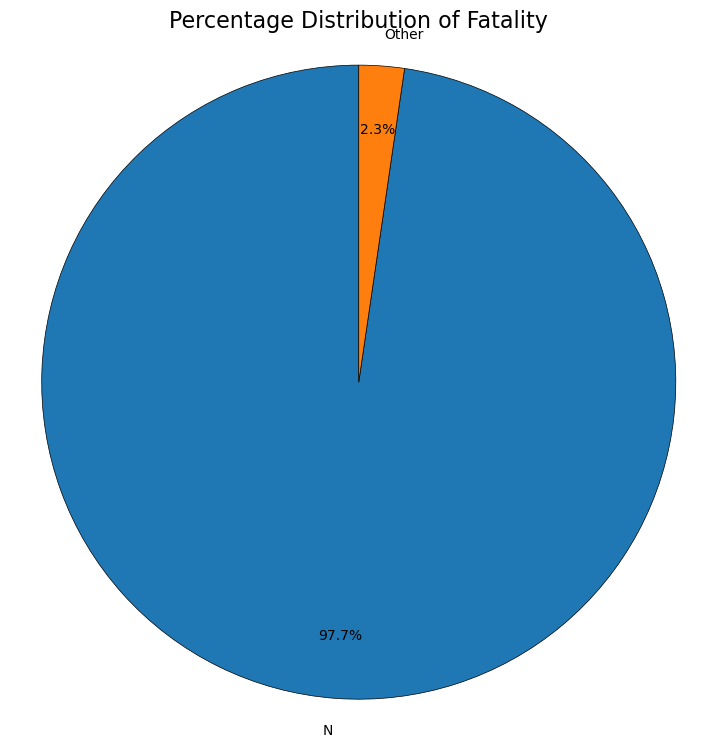

In [32]:
COLUMN_NAME = 'Fatal Y/N' # Replace with the column you want to visualize

# Get the counts for each category
category_counts = SAdf[COLUMN_NAME].value_counts()

# -----------------------------------------------------------
# 2. Filtering for Readability (Recommended)
# -----------------------------------------------------------

# Pie charts work best with a small number of slices. 
# We'll filter to include only categories that represent at least 5% of the total, 
# and group the rest into 'Other'.
threshold_percentage = 5.0
total_count = category_counts.sum()
threshold_count = total_count * (threshold_percentage / 100)

main_categories = category_counts[category_counts >= threshold_count]
other_count = category_counts[category_counts < threshold_count].sum()

if other_count > 0:
    main_categories['Other'] = other_count

# Check if the series is empty before plotting
if main_categories.empty:
    print(f"No data found in the '{COLUMN_NAME}' column to create a pie chart.")
else:
    # -----------------------------------------------------------
    # 3. Create the Pie Chart (Distributed Circle Graphic)
    # -----------------------------------------------------------
    
    plt.figure(figsize=(9, 9))
    
    plt.pie(
        main_categories.values,
        labels=main_categories.index,
        autopct='%1.1f%%', # Format percentage text
        startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
        pctdistance=0.8
    )
    
    plt.title(f'Percentage Distribution of Fatality', fontsize=16)
    plt.axis('equal') # Ensures the pie chart is a perfect circle
    plt.show()

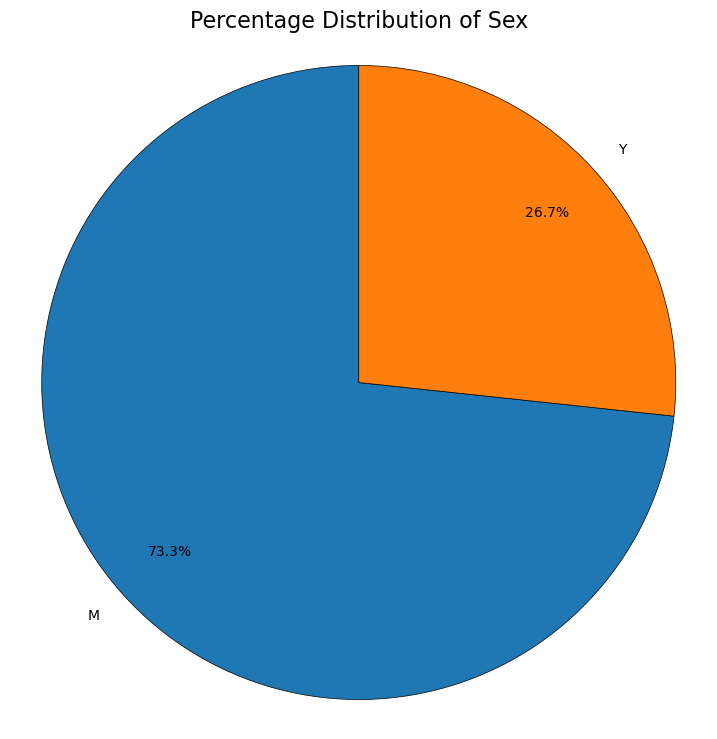

In [31]:
COLUMN_NAME = 'Sex' # Replace with the column you want to visualize

# Get the counts for each category
category_counts = SAdf[COLUMN_NAME].value_counts()

# -----------------------------------------------------------
# 2. Filtering for Readability (Recommended)
# -----------------------------------------------------------

# Pie charts work best with a small number of slices. 
# We'll filter to include only categories that represent at least 5% of the total, 
# and group the rest into 'Other'.
threshold_percentage = 5.0
total_count = category_counts.sum()
threshold_count = total_count * (threshold_percentage / 100)

main_categories = category_counts[category_counts >= threshold_count]
other_count = category_counts[category_counts < threshold_count].sum()

if other_count > 0:
    main_categories['Other'] = other_count

# Check if the series is empty before plotting
if main_categories.empty:
    print(f"No data found in the '{COLUMN_NAME}' column to create a pie chart.")
else:
    # -----------------------------------------------------------
    # 3. Create the Pie Chart (Distributed Circle Graphic)
    # -----------------------------------------------------------
    
    plt.figure(figsize=(9, 9))
    
    plt.pie(
        main_categories.values,
        labels=main_categories.index,
        autopct='%1.1f%%', # Format percentage text
        startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
        pctdistance=0.8
    )
    
    plt.title(f'Percentage Distribution of {COLUMN_NAME}', fontsize=16)
    plt.axis('equal') # Ensures the pie chart is a perfect circle
    plt.show()

In [29]:
# Ensure Sex and Age are clean (e.g., fill missing/unknowns)
SAdf['Sex'].fillna('Unknown Sex', inplace=True)
SAdf['Age'].fillna('Unknown Age', inplace=True)
SAdf['Age'] = SAdf_fatal['Age'].astype(str).str.strip()
SAdf['Sex'] = SAdf_fatal['Sex'].astype(str).str.strip()

# Create a combined demographic column for grouping
SAdf_fatal['Sex_Age_Group'] = SAdf_fatal['Sex'] + ' | ' + SAdf_fatal['Age']

# 2. Calculate the Distribution
# Get the counts for each Sex-Age group (this is the value for the pie slices)
fatality_distribution = SAdf_fatal['Sex_Age_Group'].value_counts()

# -----------------------------------------------------------
# 3. Filtering for Readability (Recommended)
# -----------------------------------------------------------

# A pie chart can be overwhelming with too many slices.
# We will combine all smaller groups into an "Other" category.

# Set a threshold (e.g., combine groups that represent less than 2% of total fatal incidents)
threshold_percentage = 2.0
total_fatal = fatality_distribution.sum()
threshold_count = total_fatal * (threshold_percentage / 100)

# Identify groups to keep and groups to merge
fatality_main = fatality_distribution[fatality_distribution >= threshold_count]
fatality_other_count = fatality_distribution[fatality_distribution < threshold_count].sum()

# Create the final Series for plotting
if fatality_other_count > 0:
    fatality_main['Other Groups'] = fatality_other_count
    
# Check if the series is empty before plotting
if fatality_main.empty:
    print("No fatal incidents found after cleaning/filtering. Cannot create pie chart.")
else:
    # -----------------------------------------------------------
    # 4. Create the Pie Chart (Distributed Circle Graphic)
    # -----------------------------------------------------------
    
    plt.figure(figsize=(10, 10))
    
    # Plot the pie chart
    plt.pie(
        fatality_main.values,
        labels=fatality_main.index,
        autopct='%1.1f%%', # Format percentage text
        startangle=90,     # Start at the top
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}, # Add borders to slices
        pctdistance=0.8    # Distance of the percentage text from the center
    )
    
    plt.title('Distribution of Fatal Incidents by Sex and Age Group', fontsize=16)
    plt.legend(title="Sex | Age", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.axis('equal') # Ensures the pie chart is a perfect circle
    plt.savefig('fatality_sex_age_pie_chart.png')
    plt.close()
    
    print("Pie chart saved as fatality_sex_age_pie_chart.png")

C:\Users\a_gal\AppData\Local\Temp\ipykernel_35644\3087895821.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  SAdf['Sex'].fillna('Unknown Sex', inplace=True)
C:\Users\a_gal\AppData\Local\Temp\ipykernel_35644\3087895821.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

TypeError: Invalid value 'Unknown Age' for dtype 'Int32'

location_order = SAdf['Location'].value_counts().index
# Select the top 20 locations for a clear visualization
top_locations = location_order[:20]

# Filter the DataFrame to include only the top locations
SAdf_top = SAdf[SAdf['Location'].isin(top_locations)].copy()


# ----------------------------------------------------------------------
# 2. Create the Count Plot (Histogram of Counts)
# ----------------------------------------------------------------------

# Set the figure size to ensure the labels are legible
plt.figure(figsize=(12, 6))

# Create the countplot:
# x='Location': The categorical column to count
# data=SAdf_top: The (filtered) DataFrame
# order=top_locations: Ensures the bars are sorted by frequency (most to least)
sns.countplot(
    x='Location',
    data=SAdf_top,
    order=top_locations,
    palette='viridis' # Use a distinct color palette
)

# 3. Enhance Readability

# Rotate the x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Add a descriptive title and labels
plt.title(f'Histogram of Occurrences for Top {len(top_locations)} Locations', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Number of Occurrences (Count)', fontsize=12)

# Ensure the layout is tight to fit all elements
plt.tight_layout()

# Display the plot
plt.show() # In a Jupyter Notebook, plt.show() might not be strictly necessary, 
           # but it's good practice.

In [20]:
SAdf.sort_values

,Year,Date,Time,Type,Sex,Age,Activity,Location,Country,State,Fatal Y/N,Time_Range,Activity_clean,Activity_grouped
16,2024,October,NaN,Unprovoked,M,27,Surfing,Martin County,USA,Florida,N,Unknown,surfing,Surfing
17,2024,October,NaN,Unprovoked,M,16,Surfing,Brevard County,USA,Florida,N,Unknown,surfing,Surfing
18,2024,July,11:15:00,Unprovoked,M,14,Diving into Water,Ponce de Leon Inlet Volusia County,USA,Florida,N,Morning,diving into water,Diving
19,2024,July,16:15:00,Unprovoked,M,26,Wading,Volusia County,USA,Florida,N,Afternoon,wading,Wading/Standing
20,2024,July,NaN,Unprovoked,Y,45,Swimming,Cameron County,USA,Texas,N,Unknown,swimming,Swimming
23,2024,July,11:00:00,Unprovoked,M,21,Playing football in the water,Volusia County,USA,Florida,N,Morning,playing football in the water,Other
24,2024,July,11:00:00,Unprovoked,M,<NA>,Swimming,Volusia County,USA,Florida,N,Morning,swimming,Swimming
25,2024,June,NaN,Unprovoked,M,49,Surfing,Goat Island (Moku'auia) La'ie Bay,USA,Hawaii,Y,Unknown,surfing,Surfing
26,2024,June,14:00:00,Unprovoked,Y,25,Unconfirmed Possibly swimming near the boat ha...,Oahu County,USA,Hawaii,N,Afternoon,unconfirmed possibly swimming near the boat ha...,Swimming
27,2024,June,15:00:00,Unprovoked,Y,15,Wading,Rosemary Beach Walton County,USA,Florida,N,Afternoon,wading,Wading/Standing


In [22]:
SAdf2 =SAdf.copy()
SAdf2.to_csv('df_dropped.csv', index=False)

In [ ]:
df.to_csv("SAdf.csv", index=False)